<a href="https://colab.research.google.com/github/aslanides/aslanides.github.io/blob/master/colabs/2019-10-25-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximate Inference via Variational Autoencoders

In this post we'll revisit a deep learning classic, _Autoencoding Variational Bayes_ [(Kingma & Welling, 2014)](https://arxiv.org/abs/1312.6114).

Say we have a probabilistic latent variable model $p(x, z)$. If we're Bayesians (and we most definite [are](https://aslanides.io/aixijs)!), then we care about doing two fundamental operations to this distribution:

- Inference: computing/sampling from the posterior distribution over latents $p(z\lvert x)$, given some data $x$, 
- Marginalization: computing/sampling from the marginal distribution $p(x)$.

Of course, because of Bayes rule

$$
p(z\lvert x) = \frac{p(x\lvert z)p(z)}{p(x)},
$$

both of these operations require us to marginalize out the latent variable $z$ to get the evidence $p(x)$, which is in general intractable. To simplify the problem, we can find a 'variational' distribution $q(z\lvert x)$ (constrained to belong in some simpler family of distributions) as an approximation to the true posterior. The central idea of variational inference is to find this approximation via optimization [(Blei et al, 2016)](https://arxiv.org/abs/1601.00670).



The model evidence (marginal log-likelihood) can be expressed as

$$
\begin{aligned}
\log p(x) &\stackrel{\mathrm{(a)}}{=} \log\int p(x|z)p(z)\mathrm{d}z \\
          &\stackrel{\mathrm{(b)}}{=} \log\int \frac{q(z|x)}{q(z|x)}p(x|z)p(z)\mathrm{d}z \\
          &\stackrel{\mathrm{(c)}}{\geq} \int \log \frac{p(x|z)p(z)}{q(z|x)} q(z|x)\mathrm{d}z \\
          &\stackrel{\mathrm{(d)}}{=} \int\log p(x|z)q(z|x)\mathrm{d}z + \int\log\frac{p(z)}{q(z|x)} q(z|x)\mathrm{d}z\\
          &\stackrel{\mathrm{(e)}}{=} \underbrace{\mathbb{E}_{q|x}\left[\log p(x|z)\right] - \mathrm{KL}\left(q(z|x)\|p(z)\right)}_{\text{Evidence lower bound ('ELBO')}}
\end{aligned}
$$

where:
- $\mathrm{(a)}$ follows from the law of total probability,
- $\mathrm{(b)}$ introduces the variational approximation $q(z\lvert x)$ via the multiplicative identity,
- $\mathrm{(c)}$ by noting that $\log(\cdot)$ is concave and using Jensen's inequality, 
- $\mathrm{(d)}$ from log laws, and
- $\mathrm{(e)}$ from the definitions of expectation and Kullback-Leibler divergence.

Now, if we parameterize our latent model as $q_\phi(z\lvert x)$ and $p_\theta(x\lvert z)$, we can amortize the inference cost over a dataset via stochastic gradient descent.
- The above implies that finding parameters $\theta,\phi$ that maximize the evidence lower bound corresponds to maximizing the marginal log-likelihood. 
- We can compute a Monte-Carlo estimate of the first term of the ELBO via mini-batches.
- We can easily compute the second (KL) term of the ELBO for certain choices of prior $p(z)$ and variational approximation $q(z\lvert x)$.

Example parameterization:

$$
q_\phi(z \lvert x) = \mathcal{N}\left(m(x), \Sigma(x)\right) \\
p_\theta(x \lvert z) = \mathrm{Bern}\left(f_\theta(z)\right)
$$

where the covariance $\Sigma$ is diagonal, i.e. we use a mean-field (factorized) Gaussian; if used in conjunction with a Gaussian prior $p(z)$, the KL term can be computed in closed form, although this factorized assumption obviously limits the expressivity of the variational model class.

Finally, we can cash this out in the language of neural networks and 'autoencoders': a network that reconstructs its inputs by passing them through an information bottleneck via an encoder/decoder pair. In information theoretic terms, this is a lossy compression scheme (similar to PCA). From this perspective, a VAE is simply a KL-regularized autoencoder for some reconstruction loss.

## MNIST experiment

We'll implement a $\beta$-VAE and train it to reconstruct MNIST images. We'll also qualitatively take a look at how well the latent codes compress the data distribution by looking at decodings of traversals.

In [0]:
# Install Sonnet 2/TensorFlow 2.
! pip install --quiet tensorflow==2.0
! pip install --quiet dm-sonnet==2.0.0b0

In [0]:
# Imports.
from typing import List, Sequence
import warnings
warnings.filterwarnings('ignore')  # Squash deprecation warnings.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

In [0]:
class Encoder(snt.Module):
  """Encoder models the variational q(z|x) as a factorized Gaussian."""

  def __init__(self, hidden_sizes: List[int], latent_size: int):
    super().__init__(name='encoder')

    self._network = snt.Sequential([
        snt.Flatten(),
        snt.nets.MLP(hidden_sizes, activate_final=True),
    ])
    
    self._mu_linear = snt.Linear(latent_size)
    self._sigma_linear = snt.Linear(latent_size)  # Diagonal covariance matrix.

  def __call__(self, x: tf.Tensor) -> tfd.Distribution:
    embedding = self._network(x)
    mu = self._mu_linear(embedding)
    sigma = tf.square(self._sigma_linear(embedding))  # To ensure sigma >= 0.
    return tfd.Normal(loc=mu, scale=sigma)

class Decoder(snt.Module):
  """Decoder models p(x|z) as a Bernoulli."""

  def __init__(self, hidden_sizes: List[int], output_shape: Sequence[int]):
    super().__init__(name='decoder')
    flat_output_shape = np.prod(output_shape)

    self._network = snt.Sequential([
        snt.nets.MLP(hidden_sizes + [flat_output_shape]),
        snt.Reshape(output_shape),
    ])
  
  def __call__(self, z: tf.Tensor) -> tfd.Distribution:
    logits = self._network(z)
    return tfd.Bernoulli(logits=logits)

In [0]:
# Hyperparameters
batch_size = 64
beta = 0.01
hidden_sizes = [100, 100]
latent_size = 10
learning_rate = 1e-3
training_steps = 1024

In [0]:
# Create dataset.
dataset = tfds.load('mnist', split=tfds.Split.ALL)
dataset = dataset.map(lambda x: tf.image.convert_image_dtype(x['image'], tf.float32))
image_shape = dataset.output_shapes.as_list()
dataset = dataset.batch(batch_size, drop_remainder=True)
dataset = dataset.repeat()
dataset = iter(dataset)

In [0]:
# Create encoder/decoder pair, latent prior, and optimizer.
encoder = Encoder(hidden_sizes=hidden_sizes, latent_size=latent_size)
decoder = Decoder(hidden_sizes=hidden_sizes, output_shape=image_shape)
prior = tfd.Normal(loc=tf.zeros(shape=latent_size), scale=tf.ones(shape=latent_size))
optimizer = snt.optimizers.Adam(learning_rate)

# Training loop.
results = []
for step in range(1, training_steps+1):
  x = next(dataset)
  with tf.GradientTape() as tape:
    # Encode & decode to create output distribution.
    q = encoder(x)
    z = q.sample()
    p = decoder(z)

    # loss = -ELBO = KL(q(z|x) || p(z)) - log p(x|z)
    kl_loss = tf.reduce_mean(q.kl_divergence(prior))
    reconstruction_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=p.logits, labels=x))
    loss = reconstruction_loss + beta * kl_loss

    # Compute & apply gradients.
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)

  # Occasionally log results
  if np.log2(step).is_integer():
    result = {
        'step': step,
        'total': loss.numpy(),
        'kl': kl_loss.numpy(),
        'reconstruction': reconstruction_loss.numpy(),
    }
    results.append(result)
    print(result)

{'step': 1, 'total': 0.74514484, 'kl': 5.233941, 'reconstruction': 0.6928054}
{'step': 2, 'total': 0.7320151, 'kl': 4.10371, 'reconstruction': 0.690978}
{'step': 4, 'total': 0.70496064, 'kl': 2.1315055, 'reconstruction': 0.6836456}
{'step': 8, 'total': 0.64349806, 'kl': 0.6262502, 'reconstruction': 0.6372356}
{'step': 16, 'total': 0.5014377, 'kl': 1.0161234, 'reconstruction': 0.4912765}
{'step': 32, 'total': 0.2971979, 'kl': 1.7772877, 'reconstruction': 0.27942502}
{'step': 64, 'total': 0.26660267, 'kl': 0.87415445, 'reconstruction': 0.2578611}
{'step': 128, 'total': 0.26116782, 'kl': 0.7796265, 'reconstruction': 0.25337157}
{'step': 256, 'total': 0.240968, 'kl': 0.90830433, 'reconstruction': 0.23188496}
{'step': 512, 'total': 0.1838022, 'kl': 1.3863117, 'reconstruction': 0.16993909}
{'step': 1024, 'total': 0.16776429, 'kl': 1.4869462, 'reconstruction': 0.15289482}


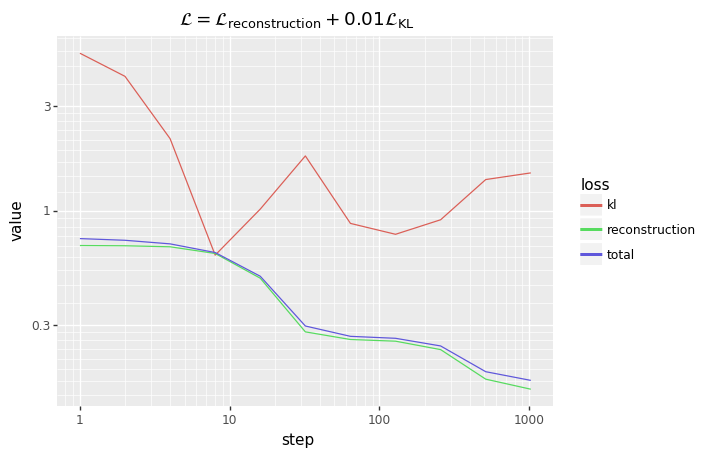

<ggplot: (8733226242708)>

In [0]:
# Plot results.
df = pd.DataFrame(results)
df = pd.melt(df, id_vars=['step'], var_name='loss')

plot = (gg.ggplot(df)
        + gg.aes(x='step', y='value', color='loss')
        + gg.geom_line()
        + gg.scale_x_log10()
        + gg.scale_y_log10()
        + gg.ggtitle('$\mathcal{L} = \mathcal{L}_\mathrm{reconstruction} + $' + f'{beta}' + '$\mathcal{L}_\mathrm{KL}$')
)
plot

## Inspecting reconstructions

Is our VAE encoding/decoding things correctly?

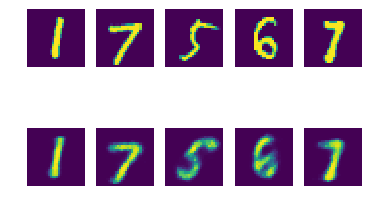

In [0]:
# Create reconstructions.
num_samples = 5
x = next(dataset)[:num_samples]
x_hat = decoder(encoder(x).sample()).probs

# Plot truth / reconstruction side-by-side.
fig, axes = plt.subplots(2, num_samples)
for n in range(num_samples):
  axes[0, n].imshow(x[n].numpy().squeeze(axis=-1))
  axes[0, n].axis('off')
  axes[1, n].imshow(x_hat[n].numpy().squeeze(axis=-1))
  axes[1, n].axis('off')
fig.show()

## Latent traversal

Let's look at what our 'decoder' produces if we draw $z$ from an evenly-spaced grid.

In [0]:
sqrt_num_samples = 10

z = np.zeros(shape=(num_samples**2, latent_size), dtype=np.float32)
xs = np.linspace(-1, 1, num=sqrt_num_samples)
ys = np.linspace(-1, 1, num=sqrt_num_samples)
xx, yy = np.meshgrid(xs, ys)
z[:, 0] = xx.flatten()
z[:, 1] = yy.flatten()

In [0]:
x_hat = decoder(z).probs.numpy().squeeze()
x_hat = x_hat.reshape([sqrt_num_samples, sqrt_num_samples] + image_shape).squeeze(-1)
x_hat = np.concatenate(x_hat, axis=-1)
x_hat = np.concatenate(x_hat, axis=0)

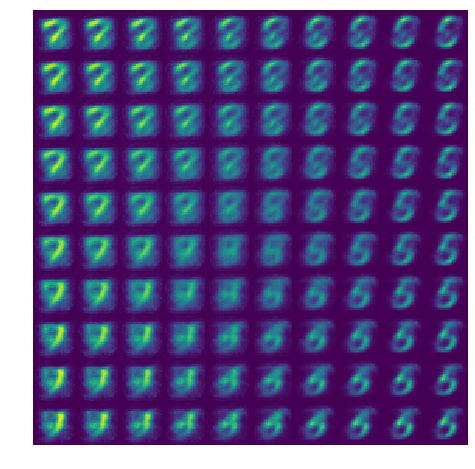

In [0]:
plt.figure(figsize=(8, 8))
plt.imshow(x_hat)
plt.axis('off')
plt.show()

## Other experiments

Other simple experiments to try:

- What advantage does the VAE have over a plain autoencoder (i.e. set $\beta=0$ in our ELBO loss.). Could sweep over various values of $\beta$.
- In the case of MNIST, what size of latent space do we need for good reconstructions / sane traversals? Do we need 10, or can we get away with fewer?